# Performance Evaluation

In [1]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (6.4, 4.8)
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.titleweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.titlepad"] = 10.0
plt.rcParams["axes.titlelocation"] = "left"
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("svg")
import seaborn as sns
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import average_precision_score, f1_score, precision_score, recall_score, balanced_accuracy_score, roc_auc_score, confusion_matrix

In [2]:
X_train = pd.read_pickle("../data/X_train.pkl")
X_train_basic = np.load("../data/X_train_basic.npy")
X_train_freq = np.load("../data/X_train_freq.npy")
X_train_ite = np.load("../data/X_train_ite.npy")
y_train = np.load("../data/y_train.npy")

In [3]:
X_train = X_train_freq

In [4]:
names = ["Constant Prediction",
         "Random Prediction",
         "K-Nearest Neighbors",
         "Linear SVM",
         "Decision Tree",
         "Logistic Regression"]

clfs = [DummyClassifier(strategy="constant", constant=1),
        DummyClassifier(strategy="uniform"),
        KNeighborsClassifier(n_neighbors=10),
        SGDClassifier(loss="hinge", class_weight="balanced"),
        DecisionTreeClassifier(max_depth=5, class_weight="balanced"),
        LogisticRegression(class_weight="balanced")]

n = len(names)

In [5]:
y_pred = {}
for name, clf in zip(names, clfs):
    y_pred[name] = cross_val_predict(clf, X_train, y_train, cv=5, n_jobs=-1)

In [6]:
y_score = {}

y_threshold = {}

for name, clf in zip(names, clfs):
    if hasattr(clf, "decision_function"):
        response_method = "decision_function"
    else:
        response_method = "predict_proba"
        
    y_score[name] = cross_val_predict(clf,
                                      X_train_freq,
                                      y_train,
                                      cv=5,
                                      n_jobs=-1,
                                      method=response_method)
    
    if name == "Logistic Regression":
        # For logistic regression, the hyperplane refered in the decision function is b_0+b_1x_1+...b_kx_k.
        # When hyperplane is 0, the probablity is 0.5,
        # therefore the threshold of decision function for logistic regression is 0.
        # https://stats.stackexchange.com/questions/329857/what-is-the-difference-between-decision-function-predict-proba-and-predict-fun
        y_threshold[name] = 0
    elif name == "Linear SVM":
        y_threshold[name] = 0
    else:
        y_score[name] = y_score[name][:, 1]
        y_threshold[name] = 0.5

## Confusion Matrix

The function `cross_val_predict` returns, for each element in the input, the prediction that was obtained for that element when it was in the test set. It is not appropriate for measuring generalisation error but suited for comparing different models.

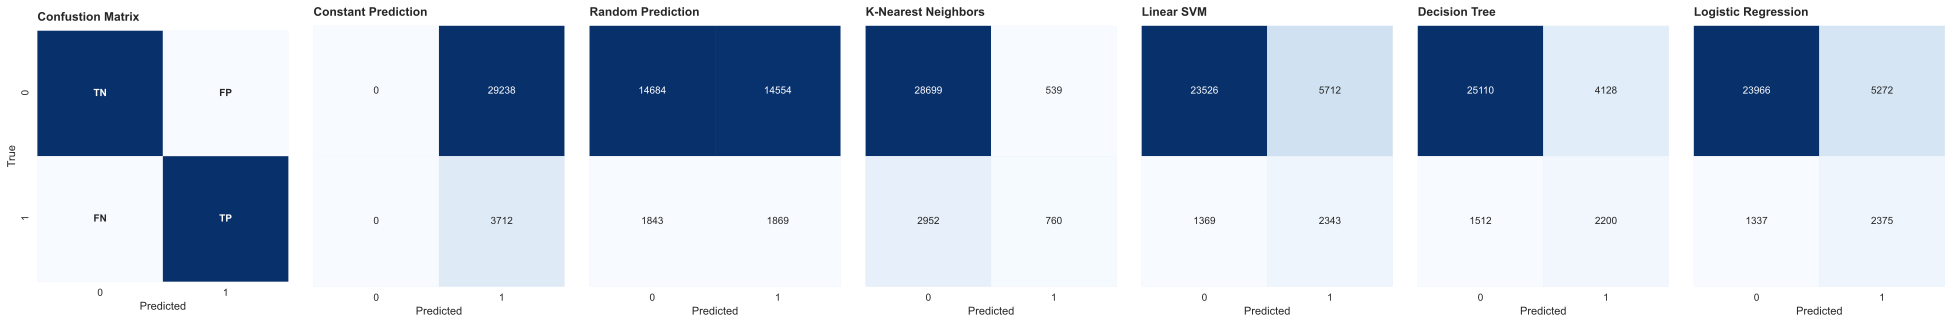

In [7]:
f, axs = plt.subplots(1, n+1, figsize=(4.8*(n+1)+0.1*n, 4.8), sharey=True, gridspec_kw=dict(wspace=0.1))

conf_mat = np.array([[100, 30], [30, 100]])
conf_label = np.array([["TN", "FP"], ["FN", "TP"]])
conf_ax = sns.heatmap(conf_mat,
                      ax=axs[0],
                      annot=conf_label,
                      annot_kws={"fontweight": "bold"},
                      fmt="",
                      square=True,
                      cmap=plt.cm.Blues, 
                      cbar=False)
conf_ax.set_xlabel("Predicted")
conf_ax.set_ylabel("True")
conf_ax.set_title("Confustion Matrix")

for i, name in zip(range(1, n+1), names):
    conf_mat = confusion_matrix(y_train, y_pred[name])
    conf_ax = sns.heatmap(conf_mat, 
                          ax=axs[i], 
                          annot=True, 
                          fmt="", 
                          cmap=plt.cm.Blues, 
                          cbar=False)
    conf_ax.set(xlabel="Predicted", title=name)

## Performance Matrics

From the Confusion Matrix, we can deride some key performance metrics. The false positive rate (FPR) measures the error rate of the negative outcomes:

$$
FPR = \frac{FP}{N} = \frac{FP}{FP+TN}
$$

The true negative rate (TNR) measures the accuracy rate for the negative outcomes:

$$
TNR = \frac{TP}{N} = \frac{TN}{TN+FP} = 1 - FPR
$$

The true positive rate (TPR) measures the accuracy rate for the positive outcomes:

$$
TPR = \frac{TP}{P} = \frac{TP}{TP+FN}
$$

Balanced accuracy is the average of true positive rate and true negative rate:

$$
bACC = \frac{TPR+TNR}{2}
$$

True positive rate is also known as recall (REC):

$$
REC = TPR = \frac{TP}{TP+FN}
$$

Precision (PRE) measures the accuracy of the predicted positive outcomes:

$$
PRE = \frac{TP}{TP+FP}
$$

To balance the up- and down-sides of optimizing PRE and REC, the harmonic mean of precision and recall is used:

$$
F_1 = 2 \cdot \frac{PRE \times REC}{PRE + REC}
$$

In [8]:
matric_names = ["FPR", "TNR", "TPR", "bACC", "REC", "PRE", "F1"]
matric_df = pd.DataFrame(index=matric_names, columns=names)

for name, clf in zip(names, clfs):
    matrics = [1-recall_score(y_train, y_pred[name], pos_label=0),
               recall_score(y_train, y_pred[name], pos_label=0),
               recall_score(y_train, y_pred[name]),
               balanced_accuracy_score(y_train, y_pred[name]),
               recall_score(y_train, y_pred[name]),
               precision_score(y_train, y_pred[name]),
               f1_score(y_train, y_pred[name])]
    matric_df[name] = matrics

matric_df

,Constant Prediction,Random Prediction,K-Nearest Neighbors,Linear SVM,Decision Tree,Logistic Regression
FPR,1.000000,0.497777,0.018435,0.195362,0.141186,0.180313
TNR,0.000000,0.502223,0.981565,0.804638,0.858814,0.819687
TPR,1.000000,0.503502,0.204741,0.631196,0.592672,0.639817
bACC,0.500000,0.502863,0.593153,0.717917,0.725743,0.729752
REC,1.000000,0.503502,0.204741,0.631196,0.592672,0.639817
PRE,0.112656,0.113804,0.585065,0.290875,0.347661,0.310579
F1,0.202498,0.185647,0.303333,0.398232,0.438247,0.418171


## Receiver Operating Characteristic

A receiver operating characteristic (ROC) is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is created by plotting TPR against FPR at various threshold settings.

In [9]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

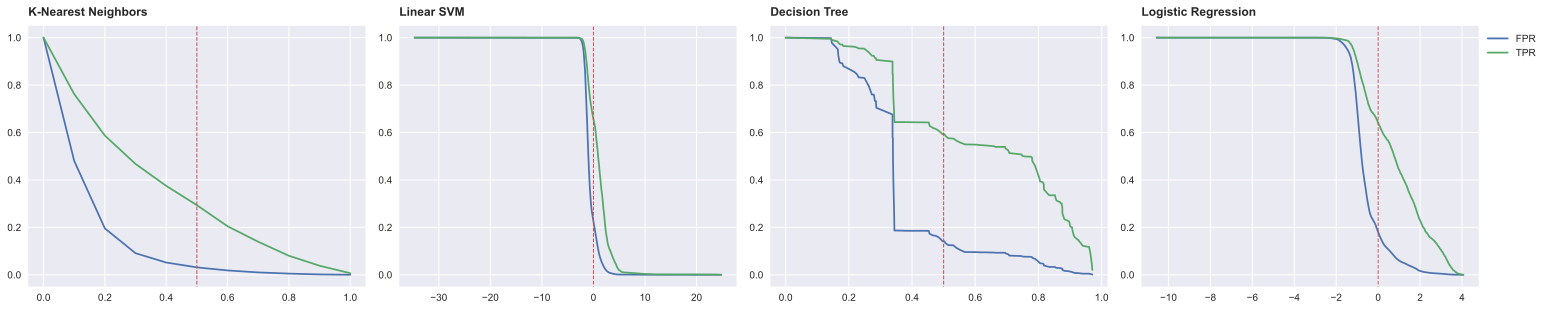

In [10]:
f, axs = plt.subplots(1, n-2, figsize=(6.4*(n-2)+0.1*(n-2), 4.8), gridspec_kw=dict(wspace=0.1))

for i, name in zip(range((n-2)), names[2:]):
    fprs, tprs, thresholds = roc_curve(y_train, y_score[name])
    roc_df = pd.DataFrame({"FPR": fprs[1:], "TPR": tprs[1:]}, index=thresholds[1:])
    ax = roc_df.plot.line(ax=axs[i], ylim=(-0.05,1.05), legend=False, title=name)
    
    threshold = y_threshold[name]
    ax.plot((threshold, threshold), (-2,2),  linestyle="--", linewidth=1)
    
#     tnrs = 1 - fprs
#     ax.plot(thresholds[1:], tnrs[1:], color="k", label="TNR")
    
    if i == n-3:
        ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

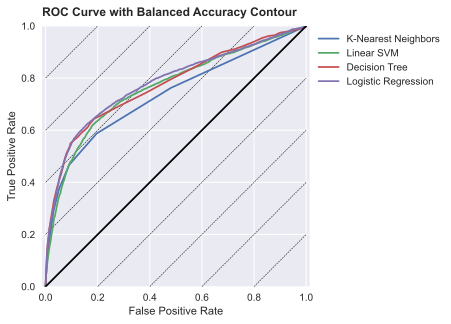

In [11]:
fig, ax = plt.subplots(figsize=(4.8, 4.8))

def bacc(x, y):
    return (1-x+y)/2

x = np.linspace(0,1,100)
y = np.linspace(0,1,100)
X, Y = np.meshgrid(x, y)
Z = bacc(X, Y)
ax.contour(X, Y, Z, levels=10, linewidths=0.5, linestyles="dashed", colors="k")

for name in names[2:]:
    fpr, tpr, thresholds = roc_curve(y_train, y_score[name])
    ax.plot(fpr, tpr, label=name)
    
ax.plot([0, 1], [0, 1], color="k")
ax.axis("equal")
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.set(xlabel="False Positive Rate",
       ylabel="True Positive Rate",
       title="ROC Curve with Balanced Accuracy Contour");

## Precision-Recall Curve

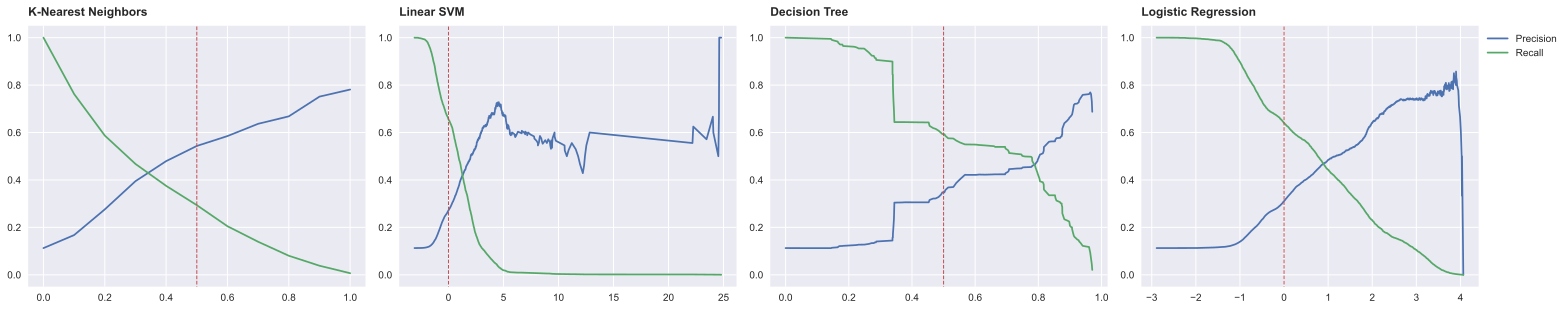

In [12]:
f, axs = plt.subplots(1, n-2, figsize=(6.4*(n-2)+0.1*(n-2), 4.8), gridspec_kw=dict(wspace=0.1))

for i, name in zip(range((n-2)), names[2:]):
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_score[name])
    precision_recall_df = pd.DataFrame({"Precision": precisions[:-1], "Recall": recalls[:-1]}, index=thresholds)
    ax = precision_recall_df.plot.line(ax=axs[i], ylim=(-0.05,1.05), legend=False, title=name)
    
    threshold = y_threshold[name]
    ax.plot((threshold, threshold), (-2,2),  linestyle="--", linewidth=1)
    
    if i == n-3:
        ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

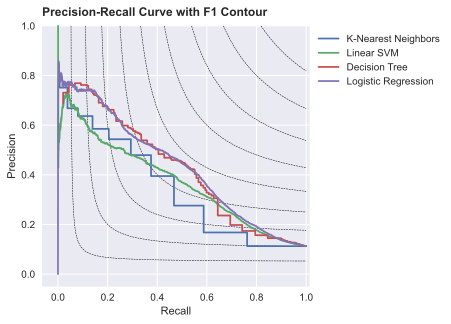

In [13]:
fig, ax = plt.subplots(figsize=(4.8, 4.8))

def f1(x, y):
    return 2*x*y/(x+y)

x = np.linspace(0.01,1)
y = np.linspace(0.01,1)
X, Y = np.meshgrid(x, y)
Z = f1(X, Y)
ax.contour(X, Y, Z, levels=10, linewidths=0.5, linestyles="dashed", colors="k")

for name in names[2:]:
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_score[name])
    precisions = precisions[:-1]
    recalls = recalls[:-1]
    ax.plot(recalls, precisions, drawstyle="steps-post", label=name)

ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.axis("equal")
ax_legend = ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax_set = ax.set(xlabel="Recall", ylabel="Precision", title="Precision-Recall Curve with F1 Contour")

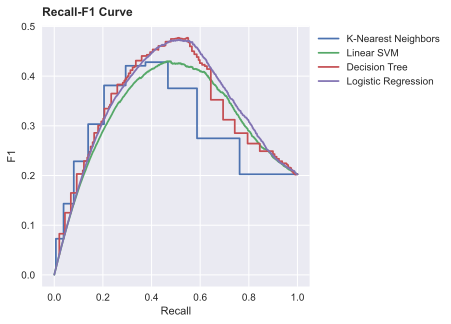

In [14]:
fig, ax = plt.subplots(figsize=(4.8, 4.8))
for name in names[2:]:
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_score[name])
    precisions = precisions[:-1]
    recalls = recalls[:-1]
    ax.plot(recalls, 2*recalls*precisions/(recalls+precisions), drawstyle="steps-post", label=name)
ax_legend = ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax_set = ax.set(xlabel="Recall", ylabel="F1", title="Recall-F1 Curve")

Average precision (AP) summarizes such a plot as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight. This implementation is not interpolated and is different from computing the area under the precision-recall curve with the trapezoidal rule, which uses linear interpolation and can be too optimistic.

$$
AP = \sum_{n} (REC_n - REC_{n-1})PRE_n
$$

In [15]:
matric_names = ["FPR", "TNR", "TPR", "bACC", "ROC", "REC", "PRE", "F1", "AP"]
matric_df = pd.DataFrame(index=matric_names, columns=names)

for name, clf in zip(names, clfs):
    matrics = [1-recall_score(y_train, y_pred[name], pos_label=0),
               recall_score(y_train, y_pred[name], pos_label=0),
               recall_score(y_train, y_pred[name]),
               balanced_accuracy_score(y_train, y_pred[name]),
               roc_auc_score(y_train, y_score[name]),
               recall_score(y_train, y_pred[name]),
               precision_score(y_train, y_pred[name]),
               f1_score(y_train, y_pred[name]),
               average_precision_score(y_train, y_score[name])]
    matric_df[name] = matrics

matric_df

,Constant Prediction,Random Prediction,K-Nearest Neighbors,Linear SVM,Decision Tree,Logistic Regression
FPR,1.000000,0.497777,0.018435,0.195362,0.141186,0.180313
TNR,0.000000,0.502223,0.981565,0.804638,0.858814,0.819687
TPR,1.000000,0.503502,0.204741,0.631196,0.592672,0.639817
bACC,0.500000,0.502863,0.593153,0.717917,0.725743,0.729752
ROC AUC,0.500000,0.500000,0.733887,0.763605,0.773813,0.781205
REC,1.000000,0.503502,0.204741,0.631196,0.592672,0.639817
PRE,0.112656,0.113804,0.585065,0.290875,0.347661,0.310579
F1,0.202498,0.185647,0.303333,0.398232,0.438247,0.418171
AP,0.112656,0.112656,0.345839,0.369646,0.422051,0.431894
